## Code required to create Figure 3
Entire notebook takes: ~8 minutes on Intel i7-10750 using > 6GB RAM

In [1]:
import glob
import re
import os
import datetime
import collections
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import jsmetrics
print(jsmetrics.__version__)

sns.set_context('paper')
sns.set_style('white')

0.1.4-alpha


In [2]:
def remove_unwanted_columns(data):
    for col in data.columns:
        if col in COLS_TO_REMOVE:
            data = data.drop(col, axis=1)
    return data

In [3]:
def make_combined_df_from_data_paths_all_scenario(data_paths, ignored_data_paths, date_format="\d{2}:\d{2}:\d{2}", data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    scenario_name = os.path.split(data_paths[first_ind])[-1].split("_")[3]
    wrote_data_name = False
    realisation_name = os.path.split(data_paths[first_ind])[-1].split("_")[4]
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2]
        wrote_data_name = True
    df.columns = ["time", data_name + "_" + scenario_name + "_" + realisation_name]
    # remove time from date
    df['time'] = df['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        scenario_name = os.path.split(f)[-1].split("_")[3]
        realisation_name = os.path.split(f)[-1].split("_")[4]
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2]
        else:
            current_data_name = data_name
        current.columns = ["time", current_data_name + "_" +  scenario_name + "_" + realisation_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
        df = df.merge(current, how='outer', on='time')
    df = df.set_index('time')
    df = df.sort_index()
    return df


def make_combined_df_from_data_paths_all_scenario_bracegirdle(data_paths, ignored_data_paths, data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    scenario_name = os.path.split(data_paths[first_ind])[-1].split("_")[3]
    realisation_name = os.path.split(data_paths[first_ind])[-1].split("_")[4]

    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2]
        wrote_data_name = True
        df.columns = ["year", data_name + "_" + scenario_name + "_" + realisation_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
    # remove time from date
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        scenario_name = os.path.split(f)[-1].split("_")[3]
        realisation_name = os.path.split(f)[-1].split("_")[4]

        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2]
        else:
            current_data_name = data_name
        current.columns = ["year", current_data_name + "_" +  scenario_name + "_" + realisation_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        df = df.merge(current, how='outer', on='year')
    df = df.set_index('year')
    df = df.sort_index()
    return df

# Globals

In [4]:
METRIC_NAMES = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", "Barnes & Simpson 2017",\
                        "Grise & Polvani 2017", "Bracegirdle et al. 2018", "Ceppi et al. 2018", "Kerr et al. 2020"]
METRIC_DATA_NAMES = ['Woollings2010_NorthPacific', 'BarnesPolvani2013_NorthPacific','BarnesPolvani2015_NorthPacific',\
                     'BarnesSimpson2017_NorthPacific','GrisePolvani2017_NorthPacific', 'Bracegirdle2018_NorthPacific',\
                     'Ceppi2018_NorthPacific', 'Kerr2020_NorthPacific']
METRIC_SHORTHAND = ["W10", "BP13", "BP15", "BS17", "GP17", "B18", "C18", "K20"]

In [5]:
METRIC_LABEL_RENAMER = dict(zip(METRIC_DATA_NAMES, METRIC_NAMES))
METRIC_SHORTHAND_LABEL_RENAMER = dict(zip(METRIC_NAMES, METRIC_SHORTHAND))

In [6]:
ALL_MONTHS = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]
ALL_MONTHS_SHORT = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [7]:
MONTH_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS))
MONTH_SHORT_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS_SHORT))

# Load ScenarioMIP

In [8]:
CMIP6_ScenarioMIP_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_AllScenarioMIP_daily_runs/outputs/ua_day*"

In [9]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Ceppi et al. 2018", "Kerr et al. 2020"]

COLS_TO_REMOVE = ["10_day_average", "plev"]

In [10]:
print("North Pacific", len(glob.glob(CMIP6_ScenarioMIP_dir + "North Pacific" + "*")))

North Pacific 3480


In [11]:
PROJ_START_DATE = "2015-01-01"
PROJ_END_DATE = "2099-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(PROJ_END_DATE) - pd.to_datetime(PROJ_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [12]:
%%time
## takes ~2 minutes on Intel i7-10750 
time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []

date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_ScenarioMIP_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except KeyError as e:
        ## we expect bracegirlde to fail this time formatting (as it is an annual metric) 
        assert str(e) == "'time'", f"failed for another reason: {e}"
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 1min 48s, sys: 3.67 s, total: 1min 52s
Wall time: 1min 53s


In [13]:
collections.Counter(time_ranges)

Counter({'2015-01-01to2100-12-31': 2045,
         '2015-01-01to2100-12-30': 474,
         '2015-01-01to2100-12-22': 146,
         '2015-01-01to2100-12-21': 79,
         '2040-01-01to2100-12-31': 48,
         '2015-01-01to2099-12-30': 48,
         '2040-01-01to2100-12-30': 30,
         '2015-01-01to2099-12-31': 12,
         '2040-01-02to2100-01-01': 12,
         '2015-01-01to2055-12-31': 12,
         '2015-01-01to2099-12-21': 8,
         '2031-01-01to2095-12-31': 7,
         '2015-01-01to2092-12-31': 6,
         '2022-01-01to2100-12-31': 6,
         '2075-01-01to2093-12-31': 6,
         '2041-01-01to2070-12-31': 6,
         '2017-01-01to2100-12-31': 6,
         '2019-01-01to2100-12-31': 6,
         '2015-01-01to2049-12-30': 6,
         '2071-01-01to2100-12-31': 6,
         '2016-01-01to2100-12-31': 6,
         '2015-01-01to2097-12-31': 6,
         '2021-01-01to2099-12-31': 6,
         '2020-01-01to2099-12-31': 6,
         '2040-01-01to2100-12-27': 5,
         '2015-01-01to2098-12-31': 5

In [14]:
len(data_paths_not_enough_days) ## all in CESM2-WACCM SSP3-7.0 (r2..1 & r3...1) [24/07/23]

14

In [15]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 436)

In [16]:
%%time
## takes ~3.5 minutes on Intel i7-10750 
all_df_npac_scenariomip_dataset = {}
for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_scenariomip_dataset[metric] = make_combined_df_from_data_paths_all_scenario_bracegirdle(glob.glob(CMIP6_ScenarioMIP_dir + metric + "*" + "North Pacific" + "*"),\
                                                                                                           ignored_data_paths=[])
        continue
    all_df_npac_scenariomip_dataset[metric] = make_combined_df_from_data_paths_all_scenario(glob.glob(CMIP6_ScenarioMIP_dir + metric + "*" + "North Pacific" + "*"),\
                                                                                           ignored_data_paths=data_paths_not_enough_days)


Woollings et al. 2010
Barnes & Polvani 2013
Barnes & Polvani 2015
Barnes & Simpson 2017
Grise & Polvani 2017
Bracegirdle et al. 2018
Ceppi et al. 2018
Kerr et al. 2020
CPU times: user 3min 27s, sys: 2.82 s, total: 3min 30s
Wall time: 3min 30s


In [17]:
len(all_df_npac_scenariomip_dataset['Woollings et al. 2010'].columns)

430

In [18]:
## check if there is any duplicates
for metric in metric_names:
    print(metric, sorted(all_df_npac_scenariomip_dataset[metric].columns[all_df_npac_scenariomip_dataset[metric].columns.map(lambda x: 'x' in x)]))

Woollings et al. 2010 []
Barnes & Polvani 2013 []
Barnes & Polvani 2015 []
Barnes & Simpson 2017 []
Grise & Polvani 2017 []
Bracegirdle et al. 2018 []
Ceppi et al. 2018 []
Kerr et al. 2020 []


#### cleaning data

In [19]:
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018

START_YEAR = PROJ_START_DATE[:4]
END_YEAR = PROJ_END_DATE[:4]
FREQ = 'd'

for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_scenariomip_dataset[metric].index = pd.date_range(start=START_YEAR, freq="y", periods=len(all_df_npac_scenariomip_dataset[metric]))
        all_df_npac_scenariomip_dataset[metric].index = all_df_npac_scenariomip_dataset[metric].index.rename('time')
    all_df_npac_scenariomip_dataset[metric].index = pd.to_datetime(all_df_npac_scenariomip_dataset[metric].index, errors='coerce')
    all_df_npac_scenariomip_dataset[metric] = all_df_npac_scenariomip_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_scenariomip_dataset[metric] = all_df_npac_scenariomip_dataset[metric][START_YEAR: END_YEAR]

In [20]:
all_df_npac_scenariomip_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_scenariomip_dataset['Woollings et al. 2010'].columns)

True

## LOAD HISTORICAL

In [21]:
## TODO: merge these into the scenario loader functions
def make_combined_df_from_data_paths(data_paths, ignored_data_paths, date_format="\d{2}:\d{2}:\d{2}", data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["time", data_name]
    # remove time from date
    df['time'] = df['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            # print(f)
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["time", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
        df = df.merge(current, how='outer', on='time')
    df = df.set_index('time')
    df = df.sort_index()
    return df


def make_combined_df_from_data_paths_for_bracegirdle(data_paths, ignored_data_paths, data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["year", data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
    # remove time from date
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["year", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        df = df.merge(current, how='outer', on='year')
    df = df.set_index('year')
    df = df.sort_index()
    return df


def remove_unwanted_columns(data):
    for col in data.columns:
        if col in COLS_TO_REMOVE:
            data = data.drop(col, axis=1)
    return data

In [22]:
HIST_START_DATE = "1950-01-01"
HIST_END_DATE = "2015-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(HIST_END_DATE) - pd.to_datetime(HIST_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [23]:
CMIP6_Historical_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_Historical_NPAC runs/ua_day*"

In [24]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Ceppi et al. 2018", "Kerr et al. 2020"]
COLS_TO_REMOVE = ["10_day_average", "plev"]

region = "North Pacific"

In [25]:
print(region, len(glob.glob(CMIP6_Historical_dir + region + "*")))

North Pacific 814


In [26]:
%%time
## takes ~27 seconds on Intel i7-10750 

time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []
date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_Historical_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except Exception as e:
#         print(e)
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 21 s, sys: 140 ms, total: 21.2 s
Wall time: 21.4 s


In [27]:
collections.Counter(time_ranges)

Counter({'1950-01-01to2014-12-31': 405,
         '1950-01-01to2014-12-30': 162,
         '1950-01-01to2015-01-01': 72,
         '1950-01-01to2014-12-27': 32,
         '1950-01-01to2014-12-21': 27,
         '1950-01-01to2015-12-31': 6,
         '1950-01-02to2014-12-31': 6,
         '1950-01-02to2014-12-28': 1,
         '1950-01-01to2015-12-22': 1})

In [28]:
len(data_paths_not_enough_days)

0

In [29]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 102)

In [30]:
%%time
## takes ~35 seconds on Intel i7-10750 
all_df_npac_hist_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                                           ignored_data_paths=[])
        continue
    all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                       ignored_data_paths=data_paths_not_enough_days)


CPU times: user 28.5 s, sys: 160 ms, total: 28.7 s
Wall time: 28.7 s


In [31]:
all_df_npac_hist_dataset['Woollings et al. 2010'].columns

Index(['ACCESS-CM2_r1i1p1f1', 'IPSL-CM6A-LR_r2i1p1f1', 'CNRM-CM6-1_r8i1p1f2',
       'CESM2_r5i1p1f1', 'CNRM-CM6-1_r4i1p1f2', 'BCC-CSM2-MR_r3i1p1f1',
       'HadGEM3-GC31-MM_r1i1p1f3', 'IPSL-CM6A-LR_r9i1p1f1',
       'ACCESS-ESM1-5_r1i1p1f1', 'UKESM1-0-LL_r1i1p1f2',
       ...
       'BCC-ESM1_r3i1p1f1', 'CanESM5_r1i1p1f1', 'BCC-CSM2-MR_r2i1p1f1',
       'GFDL-CM4_r1i1p1f1', 'CanESM5_r1i1p2f1', 'UKESM1-0-LL_r17i1p1f2',
       'IPSL-CM6A-LR_r5i1p1f1', 'INM-CM4-8_r1i1p1f1', 'IPSL-CM6A-LR_r6i1p1f1',
       'UKESM1-0-LL_r15i1p1f2'],
      dtype='object', length=101)

In [32]:
set(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns).difference(set(all_df_npac_hist_dataset['Woollings et al. 2010'].columns))

{'IITM-ESM_r1i1p1f1'}

In [33]:
%%time
## takes ~600 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = HIST_START_DATE[:4] # "1950"
END_YEAR = HIST_END_DATE[:4] # "2015"
FREQ = 'd'
for metric in metric_names:
    # print(metric)
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric].index = pd.date_range(start="1950", freq="y", periods=len(all_df_npac_hist_dataset[metric])) # NOTE: START YEAR HARD CODED
        all_df_npac_hist_dataset[metric].index = all_df_npac_hist_dataset[metric].index.rename('time')
    all_df_npac_hist_dataset[metric].index = pd.to_datetime(all_df_npac_hist_dataset[metric].index, errors='coerce')
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_hist_dataset[metric].columns:
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 307 ms, sys: 339 ms, total: 646 ms
Wall time: 650 ms


In [34]:
len(all_df_npac_hist_dataset['Woollings et al. 2010'].columns), len(all_df_npac_hist_dataset['Barnes & Polvani 2015'].columns)

(101, 101)

# Load Reanalysis

In [35]:
REAN_START_DATE = "1980-01-01"
REAN_END_DATE = "2022-12-31"
REAN_START_YEAR = REAN_START_DATE[:4]
REAN_END_YEAR = REAN_END_DATE[:4]

In [36]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[24:]##HARDCODED as starts at 1959
era_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [37]:
jra55_npac_day_dict = {}

jra55_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# jra55_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# jra55_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
jra55_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [38]:
merra2_npac_day_dict = {}

merra2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# merra2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# merra2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[3:]##HARDCODED as starts at 1980
merra2_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [39]:
ncepdoe2_npac_day_dict = {}

ncepdoe2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# ncepdoe2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[3:]##HARDCODED as starts at 1980
ncepdoe2_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [40]:
## Check length of Bracegirlde data
# len(era_npac_day_dict['Bracegirdle2018_NorthPacific']), len(jra55_npac_day_dict['Bracegirdle2018_NorthPacific']), len(merra2_npac_day_dict['Bracegirdle2018_NorthPacific']), len(ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'])

# Look at data

In [41]:
all_df_npac_scenariomip_dataset['Woollings et al. 2010'].groupby(lambda col: col.split('_')[-2] if not col.split('_')[-2] in ['x', 'y'] else col.split('_')[-2], axis=1).count().sum()

ssp119          710244
ssp126         2532150
ssp245         2416195
ssp370         3287106
ssp434          547504
ssp460          456339
ssp534-over     533538
ssp585         2403221
dtype: int64

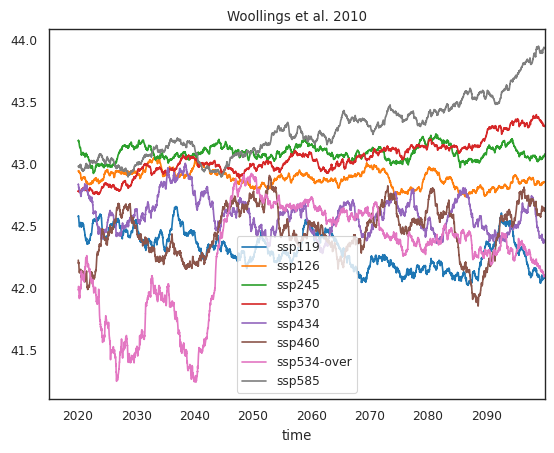

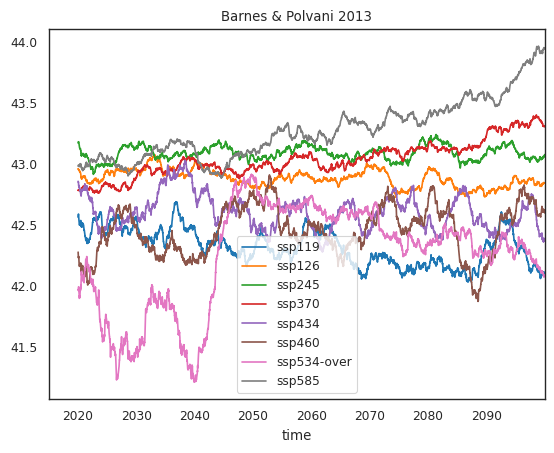

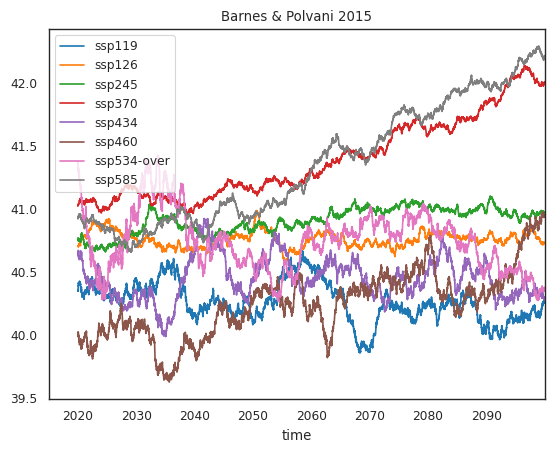

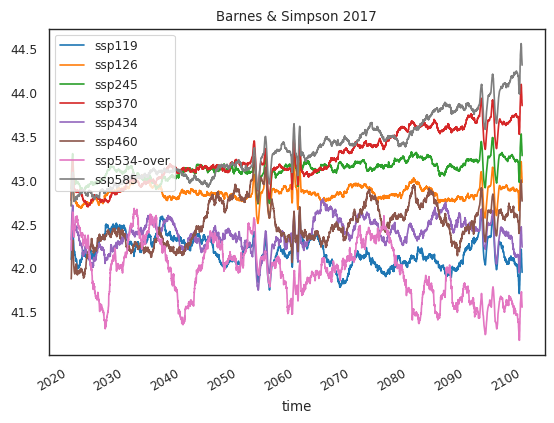

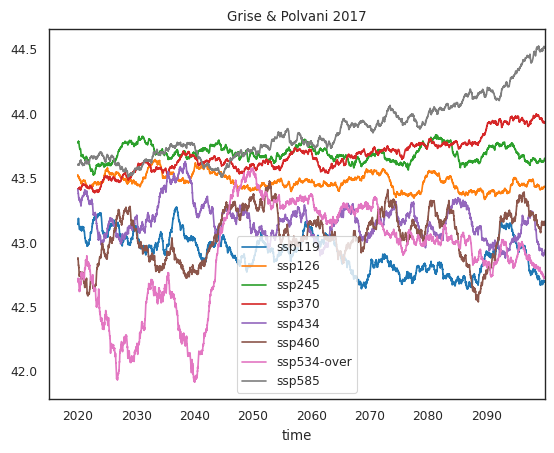

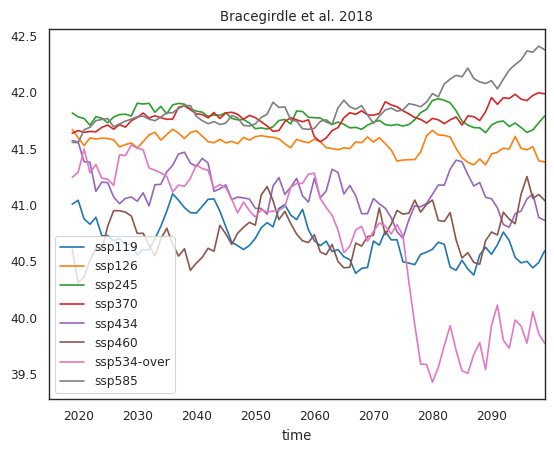

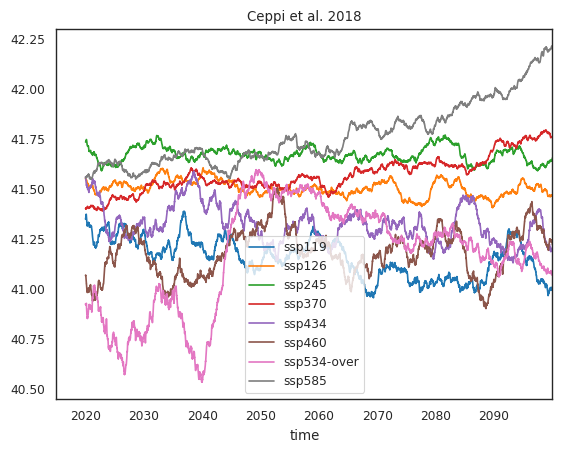

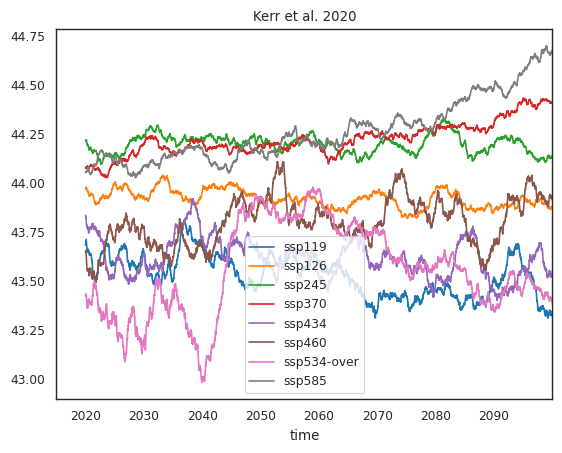

In [42]:
WINDOW_SIZE = 365
for metric in metric_names:
    fig, ax = plt.subplots(1)
    c = all_df_npac_scenariomip_dataset[metric].groupby(lambda col: col.split('_')[-2], axis=1).mean()
    if metric == "Barnes & Simpson 2017":    
        c.dropna().rolling(window=WINDOW_SIZE).mean().plot(ax=ax)
    elif metric == "Bracegirdle et al. 2018":
        c.dropna().rolling(window=WINDOW_SIZE//360*5).mean().plot(ax=ax)
    else:
        c.rolling(window=WINDOW_SIZE*5).mean().plot(ax=ax)
    ax.set_title(metric)
    plt.show()

In [43]:
def get_model_names_that_have_desired_ssp_runs(dataset_columns, ssp_runs_required):
    models_in_scenario_no_ssp = [model_name.split('_ssp')[0] + "_" + model_name.split('_')[2] for model_name in dataset_columns]
    models_with_all_req_ssps = []
    for model_name in models_in_scenario_no_ssp:
        model, real = model_name.split('_')
        model_has_all_ssp_run_required = True 
        for ssp_req in ssp_runs_required:
            ssp_model_run = model + '_' + 'ssp' + ssp_req + '_' + real
            if ssp_model_run not in dataset_columns:
                model_has_all_ssp_run_required = False
        if model_has_all_ssp_run_required:
            for ssp_req in ssp_runs_required:
                ssp_model_run = model + '_' + 'ssp' + ssp_req + '_' + real
                models_with_all_req_ssps.append(ssp_model_run)
    return models_with_all_req_ssps

In [44]:
REQUIRED_SSP_RUNS = ['126', '245', '370', '585']

In [45]:
models_with_all_req_ssp_runs = get_model_names_that_have_desired_ssp_runs(all_df_npac_scenariomip_dataset['Grise & Polvani 2017'].columns,\
                                           ssp_runs_required=REQUIRED_SSP_RUNS)

In [46]:
len(all_df_npac_scenariomip_dataset['Woollings et al. 2010'])

31046

In [47]:
len(models_with_all_req_ssp_runs)

1276

In [48]:
models_in_hist = set(all_df_npac_hist_dataset['Woollings et al. 2010'].columns)
models_in_scenario_no_ssp = [model_name.split('_ssp')[0] + "_" + model_name.split('_')[2] for model_name in models_with_all_req_ssp_runs]
models_in_scenario = set(models_in_scenario_no_ssp)

In [49]:
models_in_hist_and_all_req_scenarios = list(models_in_hist.intersection(models_in_scenario))

In [50]:
model_name_with_all_req_scenarios = []
all_ssp126_cols = []
all_ssp245_cols = []
all_ssp370_cols = []
all_ssp585_cols = []
for model_name in models_in_hist_and_all_req_scenarios:
    model, real = model_name.split('_')
    for ssp_req, ssp_list in zip(REQUIRED_SSP_RUNS,\
                                 [all_ssp126_cols, all_ssp245_cols, all_ssp370_cols, all_ssp585_cols]):
        ssp_model_run = model + '_' + 'ssp' + ssp_req + '_' + real
        ssp_list.append(ssp_model_run)
        model_name_with_all_req_scenarios.append(ssp_model_run)

In [51]:
len(model_name_with_all_req_scenarios)

144

In [52]:
number_of_models = len(collections.Counter([model_name.split('_')[0] for model_name in model_name_with_all_req_scenarios]))
print('total_num_of_models:', number_of_models)

total_num_of_models: 22


CPU times: user 42.3 s, sys: 188 ms, total: 42.5 s
Wall time: 42.4 s


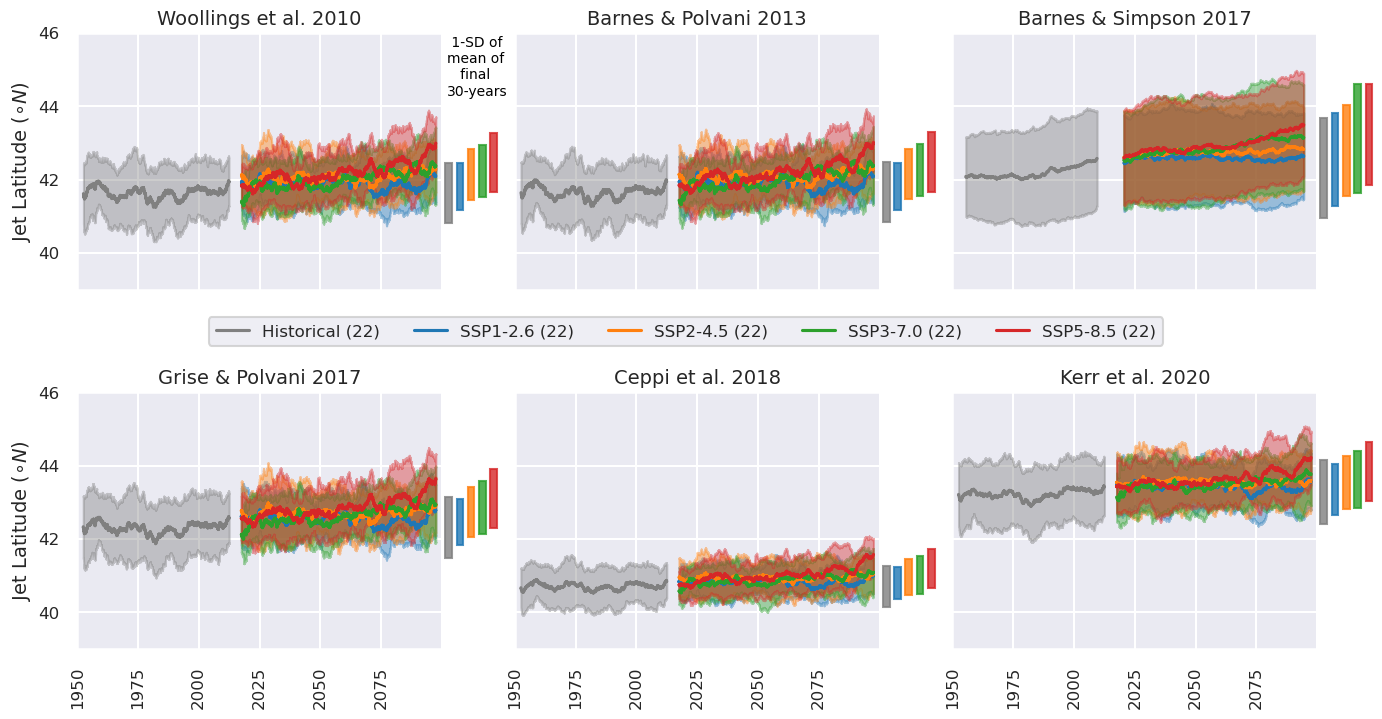

In [53]:
%%time
## Takes 45 seconds 
sns.set_context('talk')
sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
ax_list = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]
ax_ind = 0
ymin, ymax = 39, 46
use_legend=False
multiplying_factor = 5
WINDOW_SIZE = 365*multiplying_factor
for metric_to_use, metric_data_name in zip(METRIC_NAMES, METRIC_DATA_NAMES):
    ax = axes[ax_list[ax_ind][0]][ax_list[ax_ind][1]]
    if metric_to_use == 'Bracegirdle et al. 2018' or metric_to_use == 'Barnes & Polvani 2015':
        continue
    if metric_to_use == "Barnes & Simpson 2017":
        mean_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        mean_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        mean_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        mean_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        
        historical_mean = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().mean(axis=1)
        historical_std = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
    else:
        mean_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        mean_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        mean_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        mean_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
    
        historical_mean = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        historical_std = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        
    if metric_to_use == "Kerr et al. 2020":
        use_legend = True
    historical_mean.plot(ax=ax, color='grey')
    mean_all_models_ssp126.plot(ax=ax, color='C0')
    mean_all_models_ssp245.plot(ax=ax, color='C1')
    mean_all_models_ssp370.plot(ax=ax, color='C2')
    mean_all_models_ssp585.plot(ax=ax, color='C3')
    if use_legend:
        ax.legend([f"Historical ({number_of_models})", f"SSP1-2.6 ({number_of_models})", f"SSP2-4.5 ({number_of_models})",\
                   f"SSP3-7.0 ({number_of_models})", f"SSP5-8.5 ({number_of_models})"],\
                  bbox_to_anchor=(0.6,1.15), loc='lower right', fontsize=12, ncols=5)
        # ax.legend([f"Historical ({len(all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].columns)})", f"SSP1-2.6 ({len(all_ssp126_cols)})", f"SSP2-4.5 ({len(all_ssp370_cols)})",\
        #            f"SSP3-7.0 ({len(all_ssp370_cols)})", f"SSP5-8.5 ({len(all_ssp585_cols)})"],\
        #           bbox_to_anchor=(0.6,1.15), loc='lower right', fontsize=12, ncols=5)
        
    ax.fill_between((historical_mean-historical_std).dropna().index.values, (historical_mean+historical_std).dropna().values, (historical_mean-historical_std).dropna().values,\
                        color='grey', alpha=.4)
    
    ax.fill_between((mean_all_models_ssp126-std_all_models_ssp126).dropna().index.values, (mean_all_models_ssp126+std_all_models_ssp126).dropna().values, (mean_all_models_ssp126-std_all_models_ssp126).dropna().values,\
                        color='C0', alpha=.4)
    ax.fill_between((mean_all_models_ssp245-std_all_models_ssp245).dropna().index.values, (mean_all_models_ssp245+std_all_models_ssp245).dropna().values, (mean_all_models_ssp245-std_all_models_ssp245).dropna().values,\
                        color='C1', alpha=.4)
    ax.fill_between((mean_all_models_ssp370-std_all_models_ssp370).dropna().index.values, (mean_all_models_ssp370+std_all_models_ssp370).dropna().values, (mean_all_models_ssp370-std_all_models_ssp370).dropna().values,\
                        color='C2', alpha=.4)
    ax.fill_between((mean_all_models_ssp585-std_all_models_ssp585).dropna().index.values, (mean_all_models_ssp585+std_all_models_ssp585).dropna().values, (mean_all_models_ssp585-std_all_models_ssp585).dropna().values,\
                        color='C3', alpha=.4)
    ax.set_title(metric_to_use, size=14)
    ax.set_ylim(ymin, ymax)
    if ax_list[ax_ind][0] == 1:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, fontsize=12)
        ax.set_xlabel('')
    if ax_list[ax_ind][1] == 0:
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=12)
        ax.set_ylabel(r'Jet Latitude (${\circ} N$)', size=14)
        
    sd_below_mean_last_30y_historical, sd_above_mean_last_30y_historical = (historical_mean-historical_std)["1984":"2014"].mean(), (historical_mean+historical_std)["1984":"2014"].mean()
    sd_below_mean_last_30y_ssp126, sd_above_mean_last_30y_ssp126 = (mean_all_models_ssp126-std_all_models_ssp126)["2071":"2100"].mean(), (mean_all_models_ssp126+std_all_models_ssp126)["2070":"2100"].mean()
    sd_below_mean_last_30y_ssp245, sd_above_mean_last_30y_ssp245 = (mean_all_models_ssp245-std_all_models_ssp245)["2071":"2100"].mean(), (mean_all_models_ssp245+std_all_models_ssp245)["2070":"2100"].mean()
    sd_below_mean_last_30y_ssp370, sd_above_mean_last_30y_ssp370 = (mean_all_models_ssp370-std_all_models_ssp370)["2071":"2100"].mean(), (mean_all_models_ssp370+std_all_models_ssp370)["2070":"2100"].mean()
    sd_below_mean_last_30y_ssp585, sd_above_mean_last_30y_ssp585 = (mean_all_models_ssp585-std_all_models_ssp585)["2071":"2100"].mean(), (mean_all_models_ssp585+std_all_models_ssp585)["2070":"2100"].mean()
    current_xlim_max = ax.get_xlim()[1]
    if metric_to_use == "Woollings et al. 2010":
        ax.text(s=' 1-SD of\nmean of\n   final\n30-years', x=(current_xlim_max+800), y=44.3, fontsize=10, color='k')
    ax.add_patch(mpatches.Rectangle(xy=(current_xlim_max+500, sd_below_mean_last_30y_historical), width=1000, height=(sd_above_mean_last_30y_historical-sd_below_mean_last_30y_historical), color='grey', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000)+700+500, sd_below_mean_last_30y_ssp126), width=1000, height=(sd_above_mean_last_30y_ssp126-sd_below_mean_last_30y_ssp126), color='C0', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000*2)+700*2+500, sd_below_mean_last_30y_ssp245), width=1000, height=(sd_above_mean_last_30y_ssp245-sd_below_mean_last_30y_ssp245), color='C1', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000*3)+700*3+500, sd_below_mean_last_30y_ssp370), width=1000, height=(sd_above_mean_last_30y_ssp370-sd_below_mean_last_30y_ssp370), color='C2', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000*4)+700*4+500, sd_below_mean_last_30y_ssp585), width=1000, height=(sd_above_mean_last_30y_ssp585-sd_below_mean_last_30y_ssp585), color='C3', alpha=.8, clip_on= False))
    ax_ind += 1
fig.subplots_adjust(hspace=.4)
# fig.savefig("figures/figure_3.png", dpi=300, bbox_inches='tight')


## alternative add reanalysis envelope

CPU times: user 44.4 s, sys: 181 ms, total: 44.6 s
Wall time: 44.4 s


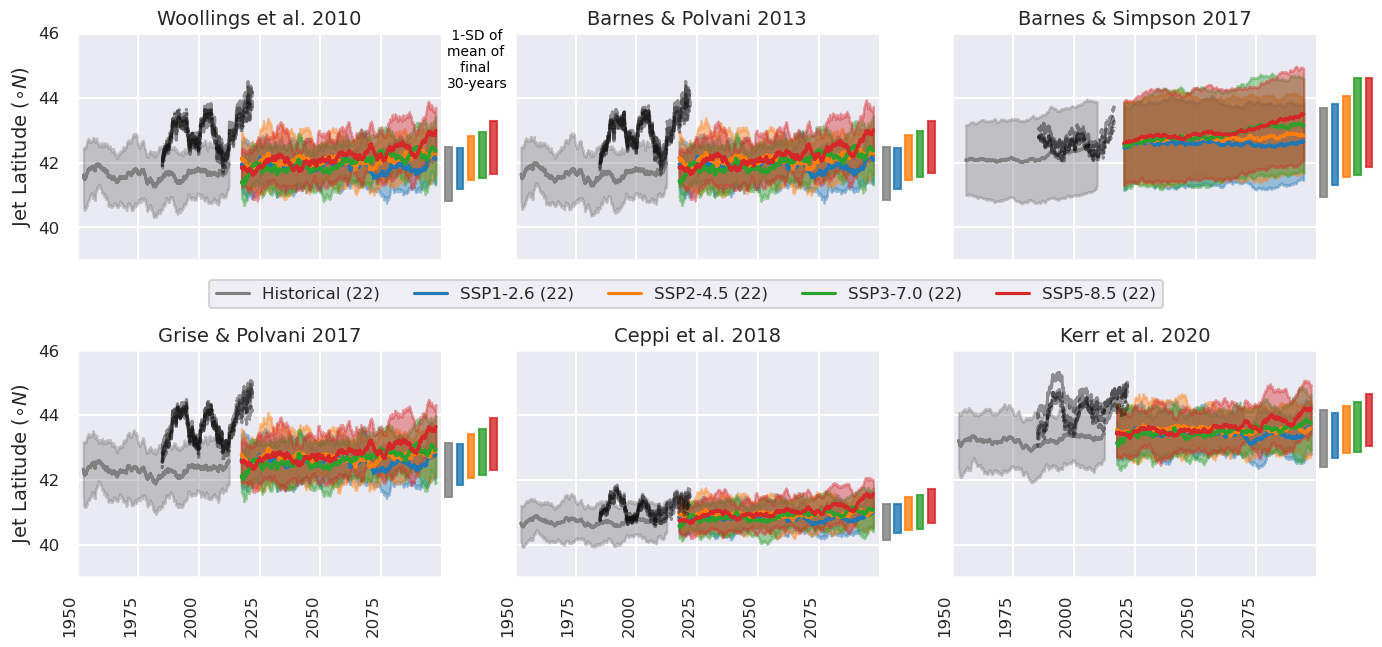

In [54]:
%%time
## Takes 45 seconds 
sns.set_context('talk')
sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
ax_list = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]
ax_ind = 0
ymin, ymax = 39, 46
use_legend=False
multiplying_factor = 5
WINDOW_SIZE = 365*multiplying_factor
for metric_to_use, metric_data_name in zip(METRIC_NAMES, METRIC_DATA_NAMES):
    ax = axes[ax_list[ax_ind][0]][ax_list[ax_ind][1]]
    if metric_to_use == 'Bracegirdle et al. 2018' or metric_to_use == 'Barnes & Polvani 2015':
        continue
    if metric_to_use == "Barnes & Simpson 2017":
        mean_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        mean_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        mean_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        mean_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].resample('11d').first().mean(axis=1).rolling(WINDOW_SIZE//multiplying_factor, center=True).mean()
        std_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].resample('11d').first().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
        
        historical_mean = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().mean(axis=1)
        historical_std = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().std(axis=1)
    else:
        mean_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp126 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp126_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        mean_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp245 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp245_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        mean_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp370 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp370_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        mean_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        std_all_models_ssp585 = all_df_npac_scenariomip_dataset[metric_to_use][all_ssp585_cols].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
    
        historical_mean = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].rolling(WINDOW_SIZE, center=True).mean().mean(axis=1)
        historical_std = all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].rolling(WINDOW_SIZE, center=True).mean().std(axis=1)
        
    if metric_to_use == "Kerr et al. 2020":
        use_legend = True
    historical_mean.plot(ax=ax, color='grey')
    mean_all_models_ssp126.plot(ax=ax, color='C0')
    mean_all_models_ssp245.plot(ax=ax, color='C1')
    mean_all_models_ssp370.plot(ax=ax, color='C2')
    mean_all_models_ssp585.plot(ax=ax, color='C3')

    era_npac_day_dict[metric_data_name].index = pd.to_datetime(era_npac_day_dict[metric_data_name].index)
    jra55_npac_day_dict[metric_data_name].index = pd.to_datetime(jra55_npac_day_dict[metric_data_name].index)
    merra2_npac_day_dict[metric_data_name].index = pd.to_datetime(merra2_npac_day_dict[metric_data_name].index)
    ncepdoe2_npac_day_dict[metric_data_name].index = pd.to_datetime(ncepdoe2_npac_day_dict[metric_data_name].index)
    
    if metric_data_name == 'BarnesSimpson2017_NorthPacific':
        era_npac_day_dict[metric_data_name].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().plot(ax=ax, c='k', alpha=.4, ls='--', legend=False)
        jra55_npac_day_dict[metric_data_name].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().plot(ax=ax, c='k', alpha=.4, ls='-.', legend=False)
        merra2_npac_day_dict[metric_data_name].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().plot(ax=ax, c='k', alpha=.4, ls='-', legend=False)
        ncepdoe2_npac_day_dict[metric_data_name].resample('11d').first().dropna().rolling(WINDOW_SIZE//multiplying_factor, center=True).mean().plot(ax=ax, c='k', alpha=.4, ls=':', legend=False)
    else:
        era_npac_day_dict[metric_data_name].rolling(WINDOW_SIZE).mean().plot(ax=ax, c='k', alpha=.4, ls='--', legend=False)
        jra55_npac_day_dict[metric_data_name].rolling(WINDOW_SIZE).mean().plot(ax=ax, c='k', alpha=.4, ls='-.', legend=False)
        merra2_npac_day_dict[metric_data_name].rolling(WINDOW_SIZE).mean().plot(ax=ax, c='k', alpha=.4, ls='-', legend=False)
        ncepdoe2_npac_day_dict[metric_data_name].rolling(WINDOW_SIZE).mean().plot(ax=ax, c='k', alpha=.4, ls=':', legend=False)
    
    if use_legend:
        ax.legend([f"Historical ({number_of_models})", f"SSP1-2.6 ({number_of_models})", f"SSP2-4.5 ({number_of_models})",\
                   f"SSP3-7.0 ({number_of_models})", f"SSP5-8.5 ({number_of_models})"],\
                  bbox_to_anchor=(0.6,1.15), loc='lower right', fontsize=12, ncols=5)
        # ax.legend([f"Historical ({len(all_df_npac_hist_dataset[metric_to_use][models_in_hist_and_all_req_scenarios].columns)})", f"SSP1-2.6 ({len(all_ssp126_cols)})", f"SSP2-4.5 ({len(all_ssp370_cols)})",\
        #            f"SSP3-7.0 ({len(all_ssp370_cols)})", f"SSP5-8.5 ({len(all_ssp585_cols)})"],\
        #           bbox_to_anchor=(0.6,1.15), loc='lower right', fontsize=12, ncols=5)
        
    ax.fill_between((historical_mean-historical_std).dropna().index.values, (historical_mean+historical_std).dropna().values, (historical_mean-historical_std).dropna().values,\
                        color='grey', alpha=.4)
    
    ax.fill_between((mean_all_models_ssp126-std_all_models_ssp126).dropna().index.values, (mean_all_models_ssp126+std_all_models_ssp126).dropna().values, (mean_all_models_ssp126-std_all_models_ssp126).dropna().values,\
                        color='C0', alpha=.4)
    ax.fill_between((mean_all_models_ssp245-std_all_models_ssp245).dropna().index.values, (mean_all_models_ssp245+std_all_models_ssp245).dropna().values, (mean_all_models_ssp245-std_all_models_ssp245).dropna().values,\
                        color='C1', alpha=.4)
    ax.fill_between((mean_all_models_ssp370-std_all_models_ssp370).dropna().index.values, (mean_all_models_ssp370+std_all_models_ssp370).dropna().values, (mean_all_models_ssp370-std_all_models_ssp370).dropna().values,\
                        color='C2', alpha=.4)
    ax.fill_between((mean_all_models_ssp585-std_all_models_ssp585).dropna().index.values, (mean_all_models_ssp585+std_all_models_ssp585).dropna().values, (mean_all_models_ssp585-std_all_models_ssp585).dropna().values,\
                        color='C3', alpha=.4)
    ax.set_title(metric_to_use, size=14)
    ax.set_ylim(ymin, ymax)
    if ax_list[ax_ind][0] == 1:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, fontsize=12)
        ax.set_xlabel('')
    if ax_list[ax_ind][1] == 0:
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=12)
        ax.set_ylabel(r'Jet Latitude (${\circ} N$)', size=14)
        
    sd_below_mean_last_30y_historical, sd_above_mean_last_30y_historical = (historical_mean-historical_std)["1984":"2014"].mean(), (historical_mean+historical_std)["1984":"2014"].mean()
    sd_below_mean_last_30y_ssp126, sd_above_mean_last_30y_ssp126 = (mean_all_models_ssp126-std_all_models_ssp126)["2071":"2100"].mean(), (mean_all_models_ssp126+std_all_models_ssp126)["2070":"2100"].mean()
    sd_below_mean_last_30y_ssp245, sd_above_mean_last_30y_ssp245 = (mean_all_models_ssp245-std_all_models_ssp245)["2071":"2100"].mean(), (mean_all_models_ssp245+std_all_models_ssp245)["2070":"2100"].mean()
    sd_below_mean_last_30y_ssp370, sd_above_mean_last_30y_ssp370 = (mean_all_models_ssp370-std_all_models_ssp370)["2071":"2100"].mean(), (mean_all_models_ssp370+std_all_models_ssp370)["2070":"2100"].mean()
    sd_below_mean_last_30y_ssp585, sd_above_mean_last_30y_ssp585 = (mean_all_models_ssp585-std_all_models_ssp585)["2071":"2100"].mean(), (mean_all_models_ssp585+std_all_models_ssp585)["2070":"2100"].mean()
    current_xlim_max = ax.get_xlim()[1]
    if metric_to_use == "Woollings et al. 2010":
        ax.text(s=' 1-SD of\nmean of\n   final\n30-years', x=(current_xlim_max+800), y=44.3, fontsize=10, color='k')
    ax.add_patch(mpatches.Rectangle(xy=(current_xlim_max+500, sd_below_mean_last_30y_historical), width=1000, height=(sd_above_mean_last_30y_historical-sd_below_mean_last_30y_historical), color='grey', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000)+700+500, sd_below_mean_last_30y_ssp126), width=1000, height=(sd_above_mean_last_30y_ssp126-sd_below_mean_last_30y_ssp126), color='C0', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000*2)+700*2+500, sd_below_mean_last_30y_ssp245), width=1000, height=(sd_above_mean_last_30y_ssp245-sd_below_mean_last_30y_ssp245), color='C1', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000*3)+700*3+500, sd_below_mean_last_30y_ssp370), width=1000, height=(sd_above_mean_last_30y_ssp370-sd_below_mean_last_30y_ssp370), color='C2', alpha=.8, clip_on= False))
    ax.add_patch(mpatches.Rectangle(xy=((current_xlim_max+1000*4)+700*4+500, sd_below_mean_last_30y_ssp585), width=1000, height=(sd_above_mean_last_30y_ssp585-sd_below_mean_last_30y_ssp585), color='C3', alpha=.8, clip_on= False))
    ax_ind += 1
fig.subplots_adjust(hspace=.4)
# fig.savefig("figures/figure_3_with_rean.png", dpi=300, bbox_inches='tight')
